## Домашнее задание

1. На нескольких алгоритмах кластеризации, умеющих работать с sparse матрицами, проверьте, что работает лучше Count_Vectorizer или TfidfVectorizer (попробуйте выжать максимум из каждого - попробуйте нграммы, символьные нграммы, разные значения max_features и min_df) (3 балла)

2. На нескольких алгоритмах кластеризации проверьте, какое матричное разложение (TruncatedSVD или NMF) работает лучше для кластеризации. (3 балла)

3. С помощью алгоритмов, умеющих выделять выбросы, попробуйте найти необычные объявления (необычные - это такие, которые непонятно к какой категории можно вообще отнести, что-то с ошибками или вообще какая-то дичь). В этом задании можно использовать любую векторизацию. (4 балла)

Используйте те же данные, что и в семинаре (колонки - title и category_name)

Делайте соответствующие вашими ресурсам и потребностям алгоритма подвыборки из всего датасета. Для сравнения используйте любую из метрик, которые есть в семинаре. Оценивать на глаз тоже можно, но тогда нужно объяснить, почему вы считаете одну кластеризацию лучше. 

НЕ ЗАБЫВАЙТЕ подбирать параметры в кластеризации. **За использование всех параметров по умолчанию, оценка будет снижаться** (под использованием всех параметров по умолчанию я имею в виду что-то такое -  `cluster = DBSCAN()`) 

Если получится, используйте метод локтя. (1 бонусный балл)

# Задание 1

In [4]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (2).csv


In [0]:
data = pd.read_csv('data.csv')
data = data[['category_name', 'title']]
sample = data.sample(frac=0.01)

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics
from sklearn.cluster import AffinityPropagation, KMeans, Birch

from tqdm import tqdm
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


 88%|████████▊ | 44/50 [00:16<00:02,  2.65it/s]/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (438) by Birch is less than (445). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)

 90%|█████████ | 45/50 [00:17<00:01,  2.67it/s]/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (438) by Birch is less than (455). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)

 92%|█████████▏| 46/50 [00:17<00:01,  2.71it/s]/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of subclusters found (438) by Birch is less than (465). Decrease the threshold.
  % (len(centroids), self.n_clusters), ConvergenceWarning)

 94%|█████████▍| 47/50 [00:17<00:01,  2.77it/s]/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_birch.py:638: ConvergenceWarning: Number of 

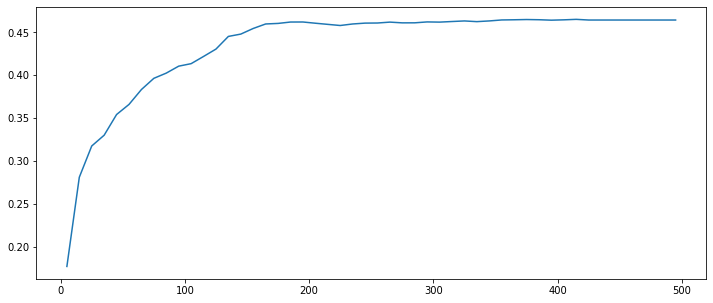

In [21]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=250)
X = vectorizer.fit_transform(sample['title'])
y = sample['category_name']

scores = []
for i in tqdm(range(5, 500, 10)):
    cluster = Birch(n_clusters=i)
    cluster.fit(X)
    scores.append(metrics.v_measure_score(y, cluster.labels_))
plt.figure(figsize=(12, 5))
plt.plot(list(range(5, 500, 10)), scores)

При числе кластеров около 200 график перестает меняться, берем это число

In [0]:
best_Birch = None
best_Birch_score = 0
for threshold in [0.3, 0.5, 0.7]:
  for branching_factor in [15, 30, 45, 60]:
    model = Birch(n_clusters=200, threshold=threshold, branching_factor=branching_factor) 
    model.fit(X)
    labels = model.labels_
    v_mes_score = metrics.v_measure_score(y, labels)
    if v_mes_score > best_Birch_score:
      best_Birch_score = v_mes_score
      best_Birch = model

In [23]:
print(best_Birch, best_Birch_score)

Birch(branching_factor=60, compute_labels=True, copy=True, n_clusters=200,
      threshold=0.5) 0.4663926854858798



100%|██████████| 10/10 [00:40<00:00,  5.51s/it]


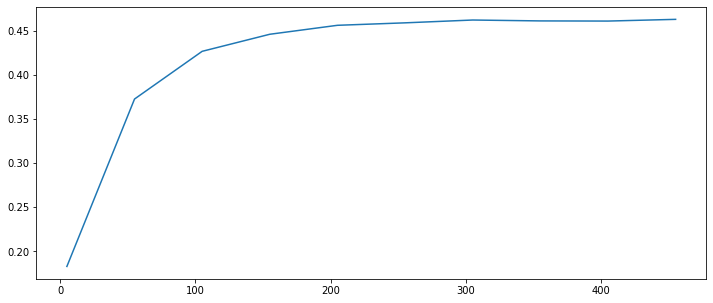

In [24]:
scores = []
for i in tqdm(range(5, 500, 50)):
    cluster = KMeans(n_clusters=i)
    cluster.fit(X)
    scores.append(metrics.v_measure_score(y, cluster.labels_))
plt.figure(figsize=(12, 5))
plt.plot(list(range(5, 500, 50)), scores)

При числе кластеров около 200 график перестает меняться, берем это число

In [0]:
best_Kmeans = None
best_Kmeans_score = 0
for max_iter in [200, 400, 600]:
  model = KMeans(max_iter=max_iter, n_clusters=200, algorithm="full")
  model.fit(X)
  labels = model.labels_
  v_mes_score = metrics.v_measure_score(y, labels)
  if v_mes_score > best_Kmeans_score:
    best_Kmeans_score = v_mes_score
    best_Kmeans = model

In [26]:
print(best_Kmeans, best_Kmeans_score)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=200, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0) 0.45763779261824433


In [0]:
def find_best_vectorizer():
  models = [
            best_Kmeans,
            best_Birch
            ]
  best_vectorizers = []
  best_scores = []
  vectorizer_grid = {
      "stopwords": ["english", None],
      "ngram_range": [(1,2), (2,2), (2,3)],
      "analyzer": ["word", "char"],
      "max_df": [0.8, 0.9],
      "max_features": [250, 500, 750]
    }
  for cluster_model in models:
    best_vect = None
    best_V_score = 0
    for vect in ["cv", "tfidf"]:
      for sw in vectorizer_grid["stopwords"]:
        for nr in vectorizer_grid["ngram_range"]:
          for an in vectorizer_grid["analyzer"]:
            for md in vectorizer_grid["max_df"]:
              for mf in vectorizer_grid["max_features"]:
                if vect == "count":
                  vectorizer = CountVectorizer(stop_words=sw, max_features=mf, max_df=md, ngram_range=nr, analyzer=an)
                else:
                  vectorizer = TfidfVectorizer(stop_words=sw, max_features=mf, max_df=md, ngram_range=nr, analyzer=an)
                X = vectorizer.fit_transform(sample['title'])
                y = sample['category_name']
                cluster_model.fit(X)
                labels = cluster_model.labels_
                v_mes_score = metrics.v_measure_score(y, labels)
                if v_mes_score > best_V_score:
                  best_vect = vectorizer
                  best_V_score = v_mes_score
    best_vectorizers.append(best_vect)
    best_scores.append(best_V_score)
  return best_vectorizers, best_scores

In [0]:
best_vect, best_sc = find_best_vectorizer()

In [30]:
for item in best_vect:
  print(item)

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=750,
                min_df=1, ngram_range=(2, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)
TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.8, max_features=500,
                min_df=1, ngram_range=(2, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)


Как мы видим, TfidfVectorizer показал себя лучше

# Задание 2

In [0]:
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.cluster import AgglomerativeClustering, MeanShift, SpectralClustering, DBSCAN


100%|██████████| 30/30 [00:07<00:00,  3.80it/s]


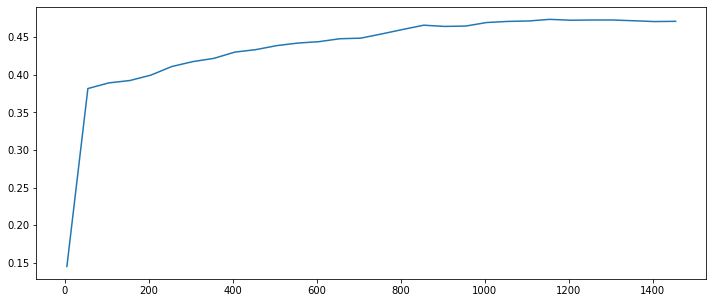

In [32]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=250)
X = vectorizer.fit_transform(sample['title'])
decomposer = NMF(50)
X = decomposer.fit_transform(X)
y = sample['category_name']

scores = []
for i in tqdm(range(5, 1500, 50)):
    cluster = AgglomerativeClustering(n_clusters=i)
    cluster.fit(X)
    scores.append(metrics.v_measure_score(y, cluster.labels_))
plt.figure(figsize=(12, 5))
plt.plot(list(range(5, 1500, 50)), scores)

При числе кластеров около 1100 график перестает меняться, берем это число

In [0]:
best_Agglo = None
best_Agglo_score = 0
for linkage in ["ward", "complete", "average", "single"]:
  model = AgglomerativeClustering(linkage=linkage, n_clusters=1100)
  model.fit(X)
  labels = model.labels_
  v_mes_score = metrics.v_measure_score(y, labels)
  if v_mes_score > best_Agglo_score:
    best_Agglo_score = v_mes_score
    best_Agglo = model

In [34]:
print(best_Agglo, best_Agglo_score)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=1100) 0.4721663866249161


In [0]:
best_Meanshift = None
best_Meanshift_score = 0
for bandwidth in [0.3, 0.5, 0.7]:
  for cluster_all in [False, True]:
    model = MeanShift(cluster_all=cluster_all, bandwidth=bandwidth)
    model.fit(X)
    labels = model.labels_
    v_mes_score = metrics.v_measure_score(y, labels)
    if v_mes_score > best_Meanshift_score:
      best_Meanshift_score = v_mes_score
      best_Meanshift = model

In [36]:
print(best_Meanshift, best_Meanshift_score)

MeanShift(bandwidth=0.3, bin_seeding=False, cluster_all=True, max_iter=300,
          min_bin_freq=1, n_jobs=None, seeds=None) 0.227930357870247





  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [00:01<00:05,  1.33s/it]


 40%|████      | 2/5 [00:04<00:05,  1.84s/it]


 60%|██████    | 3/5 [00:56<00:34, 17.04s/it]


 80%|████████  | 4/5 [02:31<00:40, 40.30s/it]


100%|██████████| 5/5 [08:13<00:00, 130.71s/it]




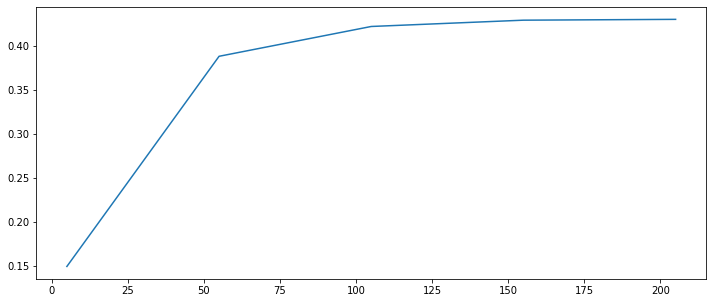

In [41]:
scores = []
for i in tqdm(range(5, 250, 50)):
    cluster = SpectralClustering(n_clusters=i)
    cluster.fit(X)
    scores.append(metrics.v_measure_score(y, cluster.labels_))
plt.figure(figsize=(12, 5))
plt.plot(list(range(5, 250, 50)), scores)

In [0]:
best_Spectral = None
best_Spectral_score = 0
for affinity in ["nearest_neighbors", "rbf"]:
  model = SpectralClustering(n_clusters=150, affinity=affinity)
  model.fit(X)
  labels = model.labels_
  v_mes_score = metrics.v_measure_score(y, labels)
  if v_mes_score > best_Spectral_score:
    best_Spectral_score = v_mes_score
    best_Spectral = model

In [46]:
print(best_Spectral, best_Spectral_score)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=150, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=None) 0.4291744311995447


In [0]:
best_Dbscan = None
best_Dbscan_score = 0
for min_samples in [1, 5, 10, 15, 20, 25, 30]:
  for eps in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]:
    model = DBSCAN(min_samples=min_samples, eps=eps) 
    model.fit(X)
    labels = model.labels_
    v_mes_score = metrics.v_measure_score(y, labels)
    if v_mes_score > best_Dbscan_score:
      best_Dbscan_score = v_mes_score
      best_Dbscan = model

In [52]:
print(best_Dbscan, best_Dbscan_score)

DBSCAN(algorithm='auto', eps=0.01, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=1, n_jobs=None, p=None) 0.441851558528172


In [0]:
def find_best_decomposition():
  models = [
            best_Agglo,
            best_Meanshift,
            best_Spectral,
            best_Dbscan
            ]
  best_decomposers = []
  best_scores = []
  decomposer_grid = {
      "n_components": [10, 30, 50, 70, 100, 150, 200],
    }
  vectorizer = TfidfVectorizer(max_df=0.8, max_features=250)
  vect_X = vectorizer.fit_transform(sample['title'])
  y = sample['category_name']
  for cluster_model in models:
    best_dec = None
    best_V_score = 0
    for de in ["svd", "nmf"]:
      for nc in decomposer_grid["n_components"]:
        if de == "svd":
          decomposer = TruncatedSVD(nc)
        else:
          decomposer = NMF(nc)
        X = decomposer.fit_transform(vect_X)
        cluster_model.fit(X)
        labels = cluster_model.labels_
        v_mes_score = metrics.v_measure_score(y, labels)
        if v_mes_score > best_V_score:
          best_dec = decomposer
          best_V_score = v_mes_score
    best_decomposers.append(best_dec)
    best_scores.append(best_V_score)
  return best_decomposers, best_scores

In [0]:
best_deco, best_dec_sc = find_best_decomposition()

In [55]:
for item in best_deco:
  print(item)
print(best_dec_sc)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)
TruncatedSVD(algorithm='randomized', n_components=150, n_iter=5,
             random_state=None, tol=0.0)
NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=200, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)
NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=150, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)
[0.4794890274729769, 0.46819880830667354, 0.43966193597678693, 0.4664399413547277]


Как мы видим, NMF в большей части случаев работает лучше

# Задание 3

In [0]:
test_samples = []
models = [
          best_Kmeans,
          best_Birch
          ]
for i in range(len(models)):
  X = best_vect[i].fit_transform(sample['title'])
  models[i].fit(X)
  new_sample = sample.copy()
  new_sample['labels'] = models[i].labels_
  test_samples.append(new_sample)

In [57]:
for t_s in test_samples:
  print(t_s[t_s.labels==-1].head())

Empty DataFrame
Columns: [category_name, title, labels]
Index: []
Empty DataFrame
Columns: [category_name, title, labels]
Index: []


In [0]:
test_samples_2 = []
models = [
          best_Agglo,
          best_Meanshift,
          best_Spectral,
          best_Dbscan
          ]
vectorizer = TfidfVectorizer(max_df=0.8, max_features=250)
vect_X = vectorizer.fit_transform(sample['title'])
for i in range(len(models)):
  X = best_deco[i].fit_transform(vect_X)
  models[i].fit(X)
  new_sample = sample.copy()
  new_sample['labels'] = models[i].labels_
  test_samples_2.append(new_sample)

In [76]:
for i in range(len(test_samples_2)):
  print(models[i])
  print(test_samples_2[i][test_samples_2[i].labels==-1].head(100))
  print()

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=1100)
Empty DataFrame
Columns: [category_name, title, labels]
Index: []

MeanShift(bandwidth=0.3, bin_seeding=False, cluster_all=True, max_iter=300,
          min_bin_freq=1, n_jobs=None, seeds=None)
Empty DataFrame
Columns: [category_name, title, labels]
Index: []

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=150, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=10, random_state=None)
Empty DataFrame
Columns: [category_name, title, labels]
Index: []

DBSCAN(algorithm='auto', eps=0.01, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=1, n_jobs=None, p=None)
Empty DataFrame
Columns: [categor

Странно, что ни один из алгоритмов не создал кластер с индексом -1; да, не все алгоритмы умеют отделять выбросы в отдельный кластер, но DBSCAN и Meanshift то точно умеют